# Reversed condition

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank, svd
import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d
from error_bounds import *

Instead of looking at the condition it might be sensible to look at the reversed condition function
$$h(A):= \frac{\sigma_n}{\sigma_1} \geq \frac{\sigma_n}{\|A\|_F} := g(A)$$

### What is the ratio between the smallest and biggest singular value?

The idea is if $A \in \mathbb{R}^{nxm}$ for $m<n$ has full rank $C>\frac{\sigma_m}{\sigma_1} > 0$ for some $C>0$, but if it does not have full rank $\frac{\sigma_m}{\sigma_1} \approx 0$

If we assume that the relative condition can bound our problem, then we have:
\begin{equation}
    | \frac{\sigma_n(A+E)}{\sigma_1(A+E)} - \frac{\sigma_n(A)}{\sigma_1(A)} | < (\frac{1}{\sigma_1}^2+\frac{\sigma_n}{\sigma_1^2}^2)\|E\|_F
\end{equation}
and
\begin{equation}
    | \frac{\sigma_n(A+E)}{\|A+E\|_F} - \frac{\sigma_n(A)}{\|A\|_F} | < (\frac{1}{\|A\|_F}+\frac{\sigma_n(A)}{\|A\|_F^2}) \ \|E\|_F
\end{equation}

In [5]:
"""
This calculates o_n/o_1
"""
def reverse_condition(A):
    sv = svd(A, compute_uv=False)
    return sv[-1]/sv[0]
    
"""
This calculates o_n/Frobenius_norm(A)
"""    
def reverse_condition_approx(A):
    sv = svd(A, compute_uv=False)
    return sv[-1]/np.linalg.norm(A)
    
def reverse_condition_bound(sv_max,sv_min,noisematrix):
    B=np.sqrt(1/sv_max+(sv_min/sv_max**2)**2)
    E=np.linalg.norm(noisematrix) 
    #print(f"(1/{sv_max:.3f} + {sv_min:.3f}/{sv_max**2:.3f})* {E:.3e} = {B:.3f}*{E:.3e}")
    return E*B

def reverse_condition_bound_approx(sv_max,sv_min,frobenius_norm_A, noisematrix):
    B=1/frobenius_norm_A + sv_min/frobenius_norm_A**2
    E=np.linalg.norm(noisematrix) 
    #print(f"(1/{frobenius_norm_A:.3f} + {sv_min:.3f}/{frobenius_norm_A**2:.3f} )* {E:.3e}= {B:.3f}*{E:.3e}")
    
    return E*B

In [6]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5e6,50
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)

0.21874134295713832
[[ -807528.2243498  -4628684.03325367 -3691703.6963974 ]
 [ -388552.44784288 -1592747.0770372  -1776310.05913231]
 [ -335091.50531212  -946821.48237687 -1531907.50674775]
 [ -221712.20888658 -4810423.35915719 -1013581.6388858 ]
 [-1005546.96405536 -4229093.71881989 -4596968.04665039]
 [ -188691.6099431  -4255736.84929466  -862624.35528739]
 [ -512957.09601727  -311112.69621904 -2345039.52971426]
 [ -172995.17587259 -2209802.3470395   -790866.38828256]
 [ -497147.07899656 -2517117.55497833 -2272762.30581602]
 [ -204697.99466986 -4152863.74528268  -935799.29565474]]


In [7]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
frobenius_norm_A=np.linalg.norm(matrix)
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio smallest/biggest singular value: {sv[-1]/sv[0]}")
print(f"Bound: {reverse_condition_bound(sv_max,sv_min,np.zeros(shape=matrix.shape))}")
print(f"Ratio smallest/Frobenius norm: {sv[-1]/frobenius_norm_A}")
print(f"Bound: {reverse_condition_bound_approx(sv_max,sv_min,np.linalg.norm(matrix),np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 2
Singular values : [1.23883298e+07 3.98493100e+06 5.23094984e-10]
Ratio smallest/biggest singular value: 4.2224819019430814e-17
Bound: 0.0
Ratio smallest/Frobenius norm: 4.0196427322264265e-17
Bound: 0.0


In [8]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t diff \t \t bound \t \t diff_approx \t bound_approx")
ratios =[]
differences=[]
bounds =[]
ratios_approx =[]
differences_approx=[]
bounds_approx =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    # Compute h
    ratio = sv[-1]/sv[0]
    difference = np.abs(ratio-sv_min/sv_max)
    bound=reverse_condition_bound(sv_max,sv_min,noise)
    # Compute g
    ratio_approx= sv[-1]/np.linalg.norm(matrix_noise)    
    difference_approx = np.abs(ratio_approx-sv_min/frobenius_norm_A)
    bound_approx=reverse_condition_bound_approx(sv_max,sv_min,frobenius_norm_A,noise)
    
    ratios.append(ratio)
    differences.append(difference)
    bounds.append(bound)
    
    ratios_approx.append(ratio_approx)
    differences_approx.append(difference_approx)
    bounds_approx.append(bound_approx)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {difference:3.3e}  \t {bound:3.3e}\t{difference_approx:3.3e}  \t {bound_approx:3.3e}")

Noise level 	 matrix rank 	 diff 	 	 bound 	 	 diff_approx 	 bound_approx
 0	 	 2 	 	 0.000e+00  	 0.000e+00	0.000e+00  	 0.000e+00
 1e-10	 	 3 	 	 5.943e-11  	 4.456e-07	5.657e-11  	 1.205e-10
 1e-09	 	 3 	 	 4.186e-10  	 3.078e-06	3.985e-10  	 8.326e-10
 1e-08	 	 3 	 	 3.803e-09  	 3.369e-05	3.620e-09  	 9.111e-09
 1e-07	 	 3 	 	 4.843e-08  	 3.288e-04	4.610e-08  	 8.894e-08
 1e-06	 	 3 	 	 3.252e-07  	 3.785e-03	3.096e-07  	 1.024e-06
 1e-05	 	 3 	 	 4.702e-06  	 3.237e-02	4.476e-06  	 8.756e-06
 0.0001	 	 3 	 	 5.977e-05  	 3.367e-01	5.689e-05  	 9.108e-05
 0.001	 	 3 	 	 3.231e-04  	 4.288e+00	3.076e-04  	 1.160e-03
 0.01	 	 3 	 	 4.787e-03  	 3.414e+01	4.555e-03  	 9.234e-03
 0.1	 	 3 	 	 7.024e-02  	 4.006e+02	6.781e-02  	 1.083e-01


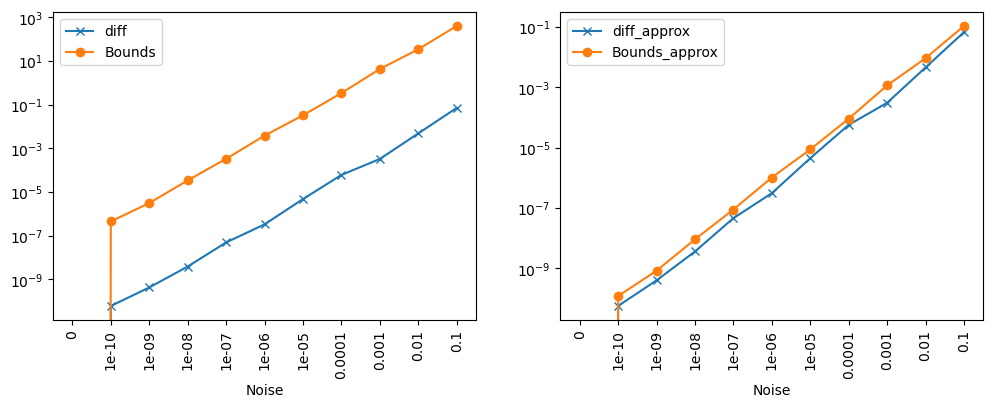

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(differences,marker='x',label="diff")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noise')
plt.legend()
plt.subplot(1,2,2)
plt.plot(differences_approx,marker='x',label="diff_approx")
plt.plot(bounds_approx,marker='o',label="Bounds_approx")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noise')
plt.legend()

### Threshold for $g(A) = \frac{\sigma_n}{\|A\|_F}$

#### Non uniqueness

We assume $\sigma_n=0$. Denote the singular value of $\tilde{A}=A+E$ by  $\tilde{\sigma}_n$ and $G=(u|u_x)$.
 $$\frac{\tilde{\sigma}_n}{\|\tilde{G}\|_F} \leq \frac{\sigma_n + \|G-\tilde{G}\|_F}{\|\tilde{G}\|_F} \leq  \frac{ \sqrt{C}}{\|\tilde{G}\|_F} = T_1$$
where $C = m(C_m \frac{\epsilon}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2$ and $\epsilon = \|u-u_{noise}\|_{\infty} + 10^{-16}$ and $h=dx$. If a value is smaller than T_1, the function u should be nonunique. Note in the following we also use the threshold
$$T_2= \frac{\frac{\epsilon}{h} + h^{order} }{\|\tilde{G}\|_F}$$
where we ignore all constants and guess \epsilon, since we can not know these in practice.

In [10]:
def calc_threshold_nonunique(frobenius_norm,eps,h,number_datapoints,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    return (eps/h+h**order)/frobenius_norm

def calc_threshold2_nonunique(frobenius_norm,eps_two,eps_infty,h,number_datapoints,M,order=2): 
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    return np.sqrt(E)/frobenius_norm

In [11]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-5, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)

dx=x[1]-x[0]

In [12]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
frobenius_norm_trueg = np.linalg.norm(true_g)
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_min/frobenius_norm_trueg:3.3e}")

M: 0.9999999948658334
Singular values of g: (36.676668447210375, 33.98267193163896)
sv_max/sv_min: 6.797e-01


In [13]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_infty = infinity_norm(u-u_noise)
    eps_two = np.linalg.norm(u-u_noise)
    
    for order in orders:          
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise = np.linalg.norm(g_noise)
        ratio=sv[-1]/frobenius_norm_gnoise
        
        threshold = calc_threshold_nonunique(frobenius_norm_gnoise,eps_infty,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2 = calc_threshold2_nonunique(frobenius_norm_gnoise,eps_two,eps_infty,dx,true_g.shape[0],M,order)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)
                                               
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

True ratio: 1.079e+00
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0


NameError: name 'ps' is not defined

### Uniqueness

##### We try a threshold for unqiue values
We choose $C>0$ such that $\sigma_n \geq C$. Then
$$\frac{\tilde\sigma_n}{\|\tilde{G}\|} \geq \frac{\sigma_n -\|\tilde{G}-G\|}{\|\tilde{G}\|} \geq \frac{C -\|\tilde{G}-G\|}{\|\tilde{G}\|} \geq \frac{C -\sqrt{E}}{\|\tilde{G}\|}$$
The ideal $C$ would be $C = \sigma_n$. However, in practice we do not know the true singular valuse. Thus, we can educately guess with:
$$C =\tilde\sigma_n-\sqrt{eps/h+h^{order}}$$
This approximates deviation we get from the derivative calculation.

In [ ]:
"""
u: function with noise
eps: noise estimation infinity_norm(u-u_noise)
"""
def educated_guess_c(u,eps,h):
    #Calculate omin omax
    order=2
    ux= ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u, h)
    u_flat, u_x_flat = u.flatten(), ux.flatten()
    g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
    omin = svd(g, compute_uv=False)[-1]
    #Calculate C  
    print(eps,h,order)
    E = (eps/h+h**order)
    print(omin,E)
    assert omin - np.sqrt(E) >0
    C = max(omin - np.sqrt(E) , 1e-14)
    return C

"""
This calculates the threshold with minimal knowlegdede
C: lower bound on >= C
eps: noise estimation infinity_norm(u-u_noise)
h: dx
order: order of the derivative caluclation
"""
def calc_threshold_uniq(C,frobenius_norm,eps,h,order=2):
    E = (eps/h+h**order)
    #assert C-np.sqrt(E) >0
    T = max((C-np.sqrt(E))/frobenius_norm,1e-13)
    return T
##This function calculates the threshold with all constants (we do not normally know)
def calc_threshold_uniq2(C,frobenius_norm,eps_two,eps_infty,M,h,number_datapoints,order=2):
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    #assert C-np.sqrt(E) >0
    T = max((C-np.sqrt(E))/frobenius_norm,1e-13)
    return T

In [ ]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1

u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C
"""

u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
"""
dx=x[1]-x[0]

In [ ]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
frobenius_norm_trueg = np.linalg.norm(true_g)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/frobenius_norm_trueg:3.3f}")

In [ ]:
#Best choice C1 C2
C=sv_min
print(f"C: {C}")

In [ ]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    C = educated_guess_c(u_noise,eps_infty,dx)
    print(f"C: {C}, Check ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise=np.linalg.norm(g_noise)
        
        ratio=sv[-1]/frobenius_norm_gnoise        
        threshold = calc_threshold_uniq(C,frobenius_norm_gnoise,eps_two,dx,order)
        threshold2 = calc_threshold_uniq2(C,frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)

        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t \t {threshold:3.3e} \t \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [ ]:
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.yscale('log')
plt.xlabel('Trial')
plt.legend()

### Combine non uniqueness and uniqueness bound

In [ ]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
b=np.random.randn()
C=1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C


u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
frobenius_norm_trueg = np.linalg.norm(true_g)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/frobenius_norm_trueg:3.3f}")

In [ ]:
M=infinity_norm(uxxx)
number_noise=2 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))
C=sv_min
for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_uniq_list = []
    threshold2_uniq_list = []
    threshold_nonunique_list = []
    threshold2_nonunique_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    #C = educated_guess_c(u_noise,eps_infty,dx)
    print(f"C: {C}, Check ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise=np.linalg.norm(g_noise)
        
        ratio=sv[-1]/frobenius_norm_gnoise   
        
        threshold_uniq = calc_threshold_uniq(C,frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_uniq = calc_threshold_uniq2(C,frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_uniq_list.append(threshold_uniq)
        threshold2_uniq_list.append(threshold2_uniq)
  
        threshold_nonunique = calc_threshold_nonunique(frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_nonunique = calc_threshold2_nonunique(frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_nonunique_list.append(threshold_nonunique)
        threshold2_nonunique_list.append(threshold2_nonunique)
        
        ratio_list.append(ratio)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
    fig.suptitle(f'Noise level {target_noise}', fontsize=16)
    
    # Subplot 1: ratio and green lines
    ax1.set_title("Non uniqueness classification")
    ax1.plot(orders, ratio_list, label='ratio', color='blue')
    ax1.plot(orders, threshold_nonunique_list, '--', label='Threshold approx', color='green')
    ax1.plot(orders, threshold2_nonunique_list, ':', label='Threshold exact', color='limegreen')
    ax1.fill_between(orders, threshold_nonunique_list, color='green', alpha=0.3)
    ax1.fill_between(orders, threshold2_nonunique_list, color='limegreen', alpha=0.3)
    ax1.set_yscale('log')
    ax1.set_ylabel('Threshold/Ratio')
    
    # Subplot 2: ratio and red lines
    ax2.set_title("Uniqueness classification")
    ax2.plot(orders, ratio_list, label='ratio', color='blue')
    ax2.plot(orders, threshold_uniq_list, '--', label='Threshold approx', color='red')
    ax2.plot(orders, threshold2_uniq_list, ':', label='Threshold exact', color='coral')
    ax2.fill_between(orders, threshold_uniq_list, y2=np.max(ratio_list), color='red', alpha=0.3)
    ax2.fill_between(orders, threshold2_uniq_list, y2=np.max(ratio_list), color='coral', alpha=0.3)
    ax2.set_yscale('log')

    
    ax2.set_xlabel('Order')
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    
    plt.show()

In [ ]:
threshold_uniq_list